In [110]:
#Imports
import numpy as np
import h5py as h5
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.cross_validation import KFold
import pickle

# Useful plotting thingies:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 12

In [5]:
#datasets
#data_path = '/projects/nikhil/ADNI_prediction/input_datasets/'
data_path = '/home/fran/workspace/NI-ML/data/'
#input data
train_val_file = data_path + 'cli_ct_seg_fused_train_plus_val.pkl'
test_file = '/projects/francisco/data/ADNI/cli_ct_seg_fused_test.pkl'

#k-fold indices (from a saved file)
kf_file = data_path + 'cli_ct_train_valid_KFold_idx.pkl'


In [86]:
#Grab CV data with specific feature columes (independent vars) and specific clinical scale (dependent var)
def load_CV_data(in_file, kf_file, clinical_scale, feature_cols):
    data = pd.read_pickle(in_file)
    data_trunc = data[clinical_scale + feature_cols]
    data_trunc = data_trunc.dropna(subset = clinical_scale + feature_cols, how='any')
    X = np.asarray(data_trunc[feature_cols], dtype=float)
    y = np.asarray(data_trunc[clinical_scale], dtype=float)
    kf = pickle.load( open(kf_file, "rb" ) )
    X_train = []
    X_valid = []
    y_train = []
    y_valid = []
    for train, valid in kf:        
        X_train.append(X[train])
        X_valid.append(X[valid])
        y_train.append(y[train])
        y_valid.append(y[valid])
    
    # Return train and validation lists comprising all folds
    return {'X_train':X_train,'X_valid':X_valid,'y_train':y_train,'y_valid':y_valid}

#Load test data
def load_test_data(in_file, clinical_scale, feature_cols):

    data = pd.read_pickle(in_file)
    data_trunc = data[clinical_scale + feature_cols]
    # remove nans
    data_trunc = data_trunc[np.isfinite(data_trunc[clinical_scale])]
    X = np.asarray(data_trunc[feature_cols],dtype=float)
    y = np.asarray(data_trunc[clinical_scale],dtype=float)
    return {'X':X, 'y':y}

In [87]:
feature_cols = ['L_HC_VOL','R_HC_VOL']
clinical_scale = ['ADAS13']

cv_data = load_CV_data(train_val_file,kf_file, clinical_scale, feature_cols)
#test_data = load_test_data(test_file, feature_cols, clinical_scale)

(522, 2)


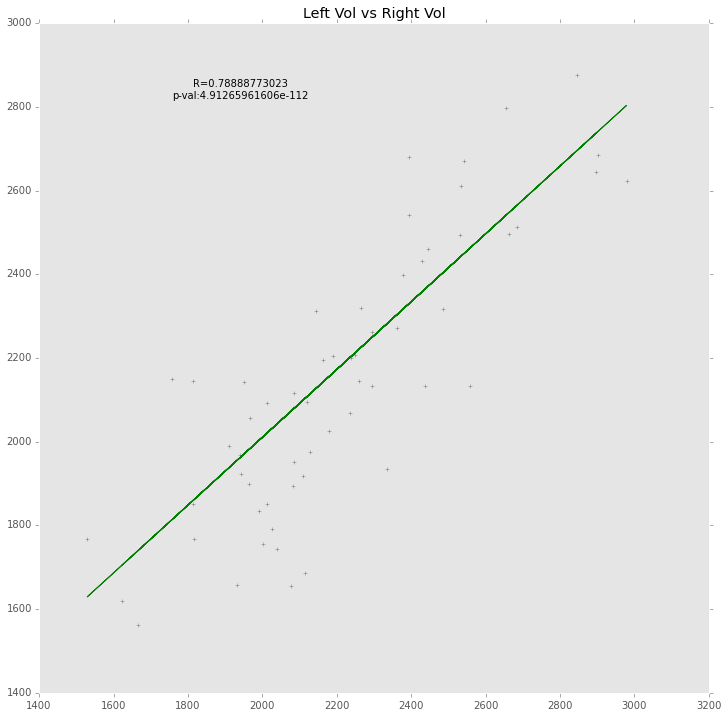

In [111]:
import scipy

# Some notes about the two hippocampal volume variables:

# First, a test for correlation between the two sides using only training data and no clinical scores:
#X_vol = np.concatenate([cv_data['X_train'][fold] for fold in range(10)])
X_vol = cv_data['X_train'][0]
X_vol_v = cv_data['X_valid'][0]
print X_vol.shape
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X_vol[:,0], X_vol[:,1])
y_hat_v = intercept + slope * X_vol_v[:,0]
        
# Plot outputs
ax=plt.subplot(1,1,1)
plt.title('Left Vol vs Right Vol')
plt.scatter(X_vol_v[:,0], X_vol_v[:,1], marker='+', color='gray')
plt.plot(X_vol_v[:,0], y_hat_v, color='green', linewidth=1)
plt.text(0.3, 0.9,'R={}\np-val:{}'.format(r_value, p_value), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)

plt.grid()    
plt.show()

In [116]:
# Define a model

# The two independent vars are highly correlated, so an ordinary least squares regression may
# be the best idea: the model will be highly sensitive to random errors in the response var. See 
# https://en.wikipedia.org/wiki/Multicollinearity

# We can instead try a ridge regression:

from sklearn.linear_model import RidgeCV
reg = RidgeCV(alphas=[0.01, 0.1, 0.5, 1.0, 5.0, 10.0], normalize=True)
# The coefficient R^2 is defined as (1 - u/v), where u is the regression sum of squares ((y_true - y_pred) ** 2).sum() 
# and v is the residual sum of squares ((y_true - y_true.mean()) ** 2).sum(). 
# Best possible score is 1.0, lower values are worse.

In [117]:
# Cross-validation loop
stats = []
coefs = []
alphas = []

for fold in range(len(cv_data['X_train'])):
    X = cv_data['X_train'][fold]
    y = cv_data['y_train'][fold]
    X_v = cv_data['X_valid'][fold]
    y_v = cv_data['y_valid'][fold]

    reg.fit(X, y)
    stats.append(reg.score(X_v,y_v))
    alphas.append(reg.alpha_)
    coefs.append(reg.coef_)
    

In [123]:
coefs = np.array(coefs)
alphas = np.array(alphas)
print 'Mode of regularization param: {}'.format(scipy.stats.mode(alphas)[0])
print 'Mean R^2: {}, STD of R^2: {}'.format(np.mean(stats), np.std(stats))
print 'Mean Coefs: {}, STD of Coefs:{}'.format(np.mean(coefs, axis=0), np.std(coefs, axis=0))

Mode of regularization param: [ 0.1]
Mean R^2: 0.0444594729612, STD of R^2: 0.0398407716024
Mean Coefs: [[-0.00286287 -0.00492385]], STD of Coefs:[[ 0.00053267  0.00035134]]
